In [1]:
import  time
from    tqdm.notebook           import  tqdm

import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  find_library
from    numerical.utils           import  *
from    numerical.distribution    import  *
from    numerical.solvers         import  *

The path [e:\_____custom_modules\python_custom_modules\numerical] will be appended.
The path [e:\_____custom_modules\python_custom_modules] will be appended.


In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = 10.0
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      np.ndarray  = np.linspace(MIN_T, MAX_T, NUM_T)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 32
MAX_V:          float       = 3.0 / LAMBDA
V:              np.ndarray  = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                )

# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      np.ndarray  = fft_index(RESOLUTION)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      np.ndarray  = freq_tensor(DIMENSION, RESOLUTION)
    
# VHS model
VHS_ALPHA:      float   = 0.0
VHS_COEFF:      float   = 1 / area_of_unit_sphere(DIMENSION)

# Metric
METRIC_ORDER:   float   = float('inf')
def metric(pred: np.ndarray, target: np.ndarray) -> float:
    numer = np.linalg.norm((pred - target).flatten(), ord=METRIC_ORDER)
    denom = np.linalg.norm(target.flatten(), ord=METRIC_ORDER)
    return float(numer / denom)


# Problem type
PROBLEM_TYPE:   str = 'bkw'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = get_bkw_coeff_ext(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = 1.0
MAXWELLIAN_MEAN_VELOCITY:       np.ndarray  = np.zeros(DIMENSION)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = 1.0

## Bimodal distribution
BIMODAL_MODE1_MEAN_DENSITY:     float       = 0.5
BIMODAL_MODE1_MEAN_VELOCITY:    np.ndarray  = np.array([MAX_V/6, *zeros(DIMENSION-1)])
BIMODAL_MODE1_MEAN_TEMPERATURE: float       = 0.5

In [ ]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
arr_f:  np.ndarray
"""A space-homogeneous initial condition"""
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
                    ARR_T, V,
                    coeff_ext   = BKW_COEFF_EXT,
                    vhs_coeff   = VHS_COEFF,
                )
    arr_f = bkw_sol[:, 0]
elif PROBLEM_TYPE == 'maxwellian':
    arr_f = maxwellian_homogeneous(
                V,
                MAXWELLIAN_MEAN_DENSITY,
                MAXWELLIAN_MEAN_VELOCITY,
                MAXWELLIAN_MEAN_TEMPERATURE,
            )
elif PROBLEM_TYPE == 'bimodal':
    arr_f = maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                +BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            ) + \
            maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                -BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            )

f_shape     = arr_f.shape[-(1+DIMENSION):-1]
f_axes_v    = tuple(range(-(1+DIMENSION), -1))


arr_f_fft = np.fft.fftn(arr_f, s=f_shape, axes=f_axes_v, norm=FFT_NORM)
"""The discrete Fourier transform of the solution sample"""

print(f"* Computing the kernel components.")
sm_object = FastSM_Boltzmann_VHS(
    dim         = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = MAX_V,
    vhs_coeff   = VHS_COEFF,
    vhs_alpha   = VHS_ALPHA,
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
)
sm_object.precompute()
print(f"\tDone. (approximation level: {sm_object.approximation_level})")

[ Initialization ]
* Setting the initial value.
----------[ BKW solution ]----------
* coeff_ext: 0.5
* coeff_int: 0.125
------------------------------------
* Computing the kernel components.
	Done. (approximation level: 1250)


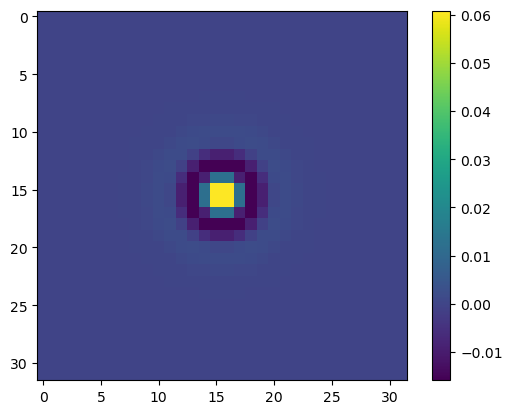

In [5]:
bkw_fft = sm_object.compute_collision_fft(None, arr_f_fft)
bkw_collision = np.fft.ifftn(bkw_fft, s=f_shape, axes=f_axes_v, norm=FFT_NORM).real
plt.imshow(bkw_collision[0].reshape(RESOLUTION, RESOLUTION))
plt.colorbar()
plt.show()

End of file